# Azure AI Search Index Creation

<img src="cohere4.jpg" width=400>

This notebook demonstrates end-to-end implementation of a **multimodal vector search system** using **Azure AI Search and Cohere Embed 4**.

The workflow covers creating a searchable index from a catalog of fashion images, generating vector embeddings for both images and text queries, and performing vector search operations to find semantically similar items.

The notebook demonstrates five core workflow phases:
- Configuration & Client Setup - Initialize connections to Azure AI Inference, Azure AI Search, and Blob Storage
- Blob Storage Integration - List and retrieve images from Azure Blob Storage containers
- Vector Embedding Generation - Create embeddings for images and text queries using Cohere Embed V4
- Index Creation & Management - Define and deploy a searchable Azure AI Search index with vector profiles
- Vector Search Operations - Query the index using both text and image embeddings to find similar items

> All fashion images are available here: https://www.kaggle.com/datasets/tbierhance/hm-fashion-images-squared-896?select=images_896x896

In [1]:
#%pip install azure-search-documents

In [2]:
import io
import json
import numpy as np
import os
import requests
import sys
import time
import tempfile

from azure.ai.inference import EmbeddingsClient, ImageEmbeddingsClient
from azure.ai.inference.models import ImageEmbeddingInput
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient, SearchIndexerClient
from azure.search.documents.indexes.models import (
    HnswAlgorithmConfiguration,
    HnswParameters,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
    SemanticConfiguration,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.storage.blob import BlobServiceClient
from datetime import datetime
from dotenv import load_dotenv
from io import BytesIO
from PIL import Image
from typing import List, Optional

In [3]:
print(f"Python version: {sys.version}")

Python version: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


In [4]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 11-Dec-2025 08:45:57


# Settings

In [5]:
load_dotenv("azure.env")

# Cohere Embed 4 deployed in Microsoft Foundry
api_key = os.getenv("api_key")
endpoint = os.getenv("endpoint")

# Azure AI Search
azure_search_endpoint = os.getenv("azure_search_endpoint")
azure_search_key = os.getenv("azure_search_key")

# Azure storage account
blob_connection_string = os.getenv("blob_connection_string")
container_name = os.getenv("container_name")

deployment_name = "embed-v-4-0"  # Name of Cohere Embed 4 model as deployed in Microsoft Foundry
index_name = "fashion-demo-2025"

In [6]:
text_client = EmbeddingsClient(endpoint=endpoint,
                               credential=AzureKeyCredential(api_key),
                               model=deployment_name)

In [7]:
image_client = ImageEmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(api_key),
    model=deployment_name,
)

# Helper

In [8]:
def display_image(image_file: str) -> None:
    """
    Download an image from Azure Blob Storage and display it in a Jupyter notebook.
    
    This function retrieves an image file from the configured blob container,
    resizes it to fit within a 640x640 thumbnail, and renders it in the
    notebook environment using IPython's display function.
    
    Args:
        image_file (str): The name/path of the image file in the blob container.
    
    Returns:
        None. Displays the image as a side effect using IPython.display().
    """
    blob_client = container_client.get_blob_client(image_file)
    blob_image = container_client.get_blob_client(
        image_file).download_blob().readall()

    # Create an in-memory stream
    image_stream = io.BytesIO(blob_image)

    # Open and display the image
    print(f"Image: {image_file}")
    image = Image.open(image_stream)
    image.thumbnail((640, 640), Image.LANCZOS)
    
    display(image)

In [9]:
def get_text_embeddings(text: str) -> list[float]:
    """
    Generate text embeddings using Cohere V4 embedding model.
    
    Converts input text into a dense vector representation (embedding) that
    captures semantic meaning, suitable for similarity comparisons, clustering,
    or retrieval tasks. Uses the configured deployment and text client for
    Azure OpenAI API access.
    
    Args:
        text (str): The input text to embed. Must not be empty or whitespace-only.
    
    Returns:
        list[float]: A list of floats representing the embedding vector for the input text.
    """
    if not text or not text.strip():
        raise ValueError("Input text cannot be empty")

    try:
        response = text_client.embed(
            input=[text.strip()],
            model=deployment_name,
        )
        return response.data[0].embedding
        
    except Exception as e:
        print("❌ Error")
        logging.error(f"Failed to generate embeddings: {e}")
        raise

In [10]:
def get_local_image_embeddings(image_path: str) -> list[float]:
    """
    Generate embeddings for a local image file using Cohere Embed 4.
    
    Converts an image file into a dense vector representation (embedding) that
    captures visual content and semantic meaning. The embedding can be used for
    image similarity comparisons, visual search, or multimodal retrieval tasks.
    
    Args:
        image_path (str): The file path to a local JPG image file to embed.
    
    Returns:
        list[float]: A list of floats representing the embedding vector for the input image.
    """
    try:
        image_input = ImageEmbeddingInput.load(
            image_file=image_path,
            image_format="jpg",
        )
        response = image_client.embed(input=[image_input])
        return response.data[0].embedding
        
    except Exception as e:
        print("❌ Error")
        logging.error(f"Failed to generate embeddings: {e}")
        raise

In [11]:
def get_image_embeddings_from_blob(blob_name: str) -> list[float]:
    """
    Generate embeddings with Cohere Embed 4 for an image stored in Azure Blob Storage.
    
    Downloads an image blob to a temporary local file, generates embeddings using
    Cohere Embed 4, and cleans up the temporary file. This function
    bridges blob storage access with the embedding generation pipeline for images
    hosted in cloud storage.
    
    Args:
        blob_name (str): The name/path of the image blob in the configured container.
    
    Returns:
        list[float]: A list of floats representing the embedding vector for the blob image.
    """
    try:
        # Download blob to temporary file
        blob_service_client = BlobServiceClient.from_connection_string(
            blob_connection_string)
        blob_client = blob_service_client.get_blob_client(
            container=container_name, blob=blob_name)

        # Create temp file with proper extension
        with tempfile.NamedTemporaryFile(delete=False,
                                         suffix='.jpg') as tmp_file:
            tmp_path = tmp_file.name
            blob_data = blob_client.download_blob()
            blob_data.readinto(tmp_file)

        # Generate embeddings using your existing function
        embeddings = get_local_image_embeddings(tmp_path)

        # Clean up temp file
        os.unlink(tmp_path)

        return embeddings

    except Exception as e:
        print("❌ Error")
        logging.error(f"Failed to process blob image: {e}")
        raise

In [12]:
def get_cosine_similarity(vector1:list[float], vector2:list[float]) -> float:
    """
    Compute the cosine similarity between two numeric vectors.

    Cosine similarity measures the cosine of the angle between two vectors,
    providing a value between -1 and 1:
        - 1 indicates identical orientation (maximum similarity).
        - 0 indicates orthogonality (no similarity).
        - -1 indicates opposite orientation.

    Args:
        vector1 (array-like): First vector (list, tuple, or NumPy array).
        vector2 (array-like): Second vector (list, tuple, or NumPy array).

    Returns:
        float: Cosine similarity score between the two vectors.

    """
    try:
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
        
        cos_simil = np.dot(vector1, vector2) / (norm1 * norm2)
        return cos_simil
    
    except (ValueError, TypeError) as e:
        print(f"Error calculating similarity: {e}")
        return None

In [13]:
def delete_index(index_name: str) -> None:
    """
    Delete an Azure AI Search index.
    
    Removes an entire search index from the Azure AI Search service, including
    all documents, fields, and configurations. This operation is irreversible
    and cannot be undone. Use with caution in production environments.
    
    Args:
        index_name (str): The name of the search index to delete.
    
    Returns:
        None. Prints status messages to console as side effects.
    """
    search_client = SearchIndexClient(
        endpoint=azure_search_endpoint,
        credential=AzureKeyCredential(azure_search_key))

    print(f"🗑️ Deleting the Azure AI Search index '{index_name}'")
    search_client.delete_index(index_name)
    print("✅ Done")

In [14]:
def upload(documents: list[dict]) -> int:
    """
    Upload documents to an Azure AI Search index.
    
    Uploads a batch of documents to the configured Azure AI Search index.
    Each document should contain the fields defined in the index schema,
    including a required key field for unique identification.
    
    Returns:
        int: The number of documents successfully uploaded.    
    """
    if not documents:
        raise ValueError("Documents list cannot be empty")
    
    search_client = SearchClient(
        endpoint=azure_search_endpoint,
        index_name=index_name,
        credential=AzureKeyCredential(azure_search_key),
    )
    
    try:
        response = search_client.upload_documents(documents)
        return len(documents)
    except Exception as e:
        logging.error(f"Failed to upload documents: {e}")
        raise

In [15]:
def get_index_stats(index_name: str) -> tuple[int, int]:
    """
    Retrieve statistics for an Azure AI Search index.
    
    Fetches index metadata including document count and storage size from the
    Azure AI Search service. Uses the REST API directly to query index statistics,
    providing insights into index usage and capacity.
    
    Args:
        index_name (str): The name of the search index to retrieve statistics for.
    
    Returns:
        tuple[int, int]: A tuple containing:
            - document_count (int): The total number of documents in the index
            - storage_size (int): The total storage size in bytes used by the index    
    """
    url = f"{azure_search_endpoint}/indexes/{index_name}/stats?api-version=2025-09-01"
    
    headers = {
        "Content-Type": "application/json",
        "api-key": azure_search_key,
    }
    
    response = requests.get(url, headers=headers)
    print(f"Azure AI Search index status for: {index_name}\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res['documentCount']
        storage_size = res['storageSize']

    else:
        print(f"❌ Request failed with status code: {response.status_code}")

    return document_count, storage_size

In [16]:
def get_index_status(index_name: str) -> None:
    """
    Retrieve detailed configuration and status information for an Azure AI Search index.
    
    Fetches complete index metadata including schema definition, field configurations,
    analyzers, and other index settings from the Azure AI Search service. Useful for
    verifying index structure and validating configurations.
    
    Args:
        index_name (str): The name of the search index to retrieve status for.
    
    Returns:
        None. Prints the index configuration JSON to console as a side effect.

    """
    print(f"🔄 Azure AI Search Index: {index_name}\n")

    headers = {"Content-Type": "application/json", "api-key": azure_search_key}
    params = {"api-version": "2025-09-01"}  # last GA api version. Subject to change
    
    index_status = requests.get(
        f"{azure_search_endpoint}/indexes/{index_name}",
        headers=headers,
        params=params)

    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("❌ Request failed")

# Connect to Blob Storage

Retrieve your images from Blob Storage.
All the fashion images are in one blob storage.

In [17]:
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(container_name)
blobs = container_client.list_blobs()

first_blob = next(blobs)
blob_url = container_client.get_blob_client(first_blob).url
print(f"URL of the first blob: {blob_url}")

URL of the first blob: https://azurestorageaccountsr.blob.core.windows.net/fashionimages/fashion/0390469004.jpg


# Connect your Blob Storage to a data source in Azure AI Search

In [18]:
# Create a data source
ds_client = SearchIndexerClient(azure_search_endpoint,
                                AzureKeyCredential(azure_search_key))

container = SearchIndexerDataContainer(name=container_name)

data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-blob",
    type="azureblob",
    connection_string=blob_connection_string,
    container=container,
)

data_source = ds_client.create_or_update_data_source_connection(data_source_connection)
print(f"✅ Done: Data source '{data_source.name}' has been created or updated.")

✅ Done: Data source 'fashion-demo-2025-blob' has been created or updated.


# Our images

In [19]:
blob_service_client = BlobServiceClient.from_connection_string(
    blob_connection_string)

container_client = blob_service_client.get_container_client(container_name)
number_images = len(list(container_client.list_blobs()))

print(f"🖼️ Total number of images = {number_images} in Azure Storage container '{container_name}'")

🖼️ Total number of images = 10226 in Azure Storage container 'fashionimages'


Image: fashion/0646756001.jpg


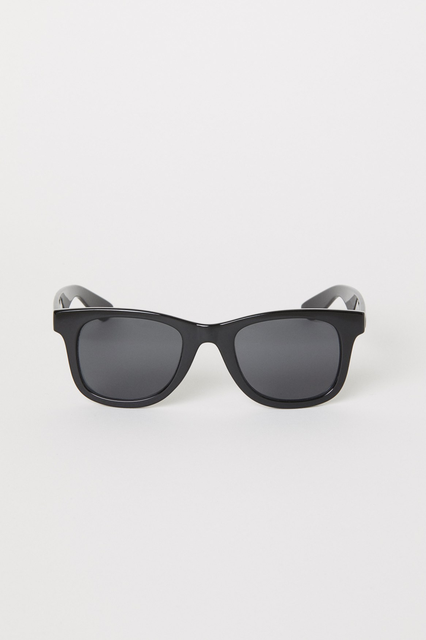

In [20]:
image_path = "fashion/0646756001.jpg"

display_image(image_path)

# Embeddings functions

In [21]:
query = "Hi"

text_emb = get_text_embeddings(query)
print(f"Size of the vector embeddings = {len(text_emb)}")

Size of the vector embeddings = 1536


In [22]:
image_path = "fashion/0646756002.jpg"

image_emb1 = get_image_embeddings_from_blob(image_path)
print(f"Size of the vector embeddings = {len(image_emb1)}")

Size of the vector embeddings = 1536


Image: fashion/0646756002.jpg


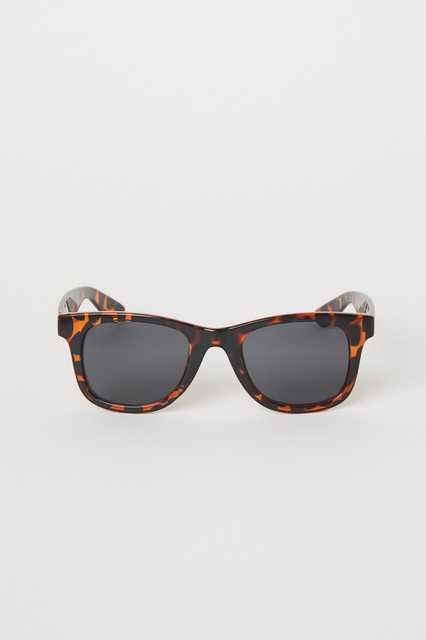

In [23]:
display_image(image_path)

In [24]:
image_path = "fashion/0696732003.jpg"

image_emb2 = get_image_embeddings_from_blob(image_path)
print(f"Size of the vector embeddings = {len(image_emb2)}")

Size of the vector embeddings = 1536


Image: fashion/0696732003.jpg


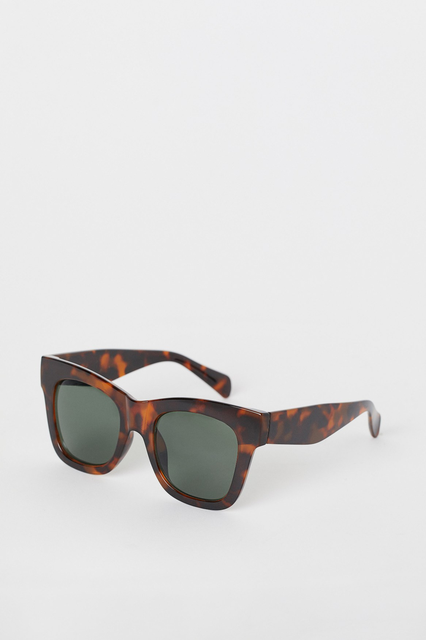

In [25]:
display_image(image_path)

In [26]:
similarity_score = get_cosine_similarity(image_emb1, image_emb2)
print(f"Cosine similarity = {similarity_score}")

Cosine similarity = 0.8469351368458564


# Generating the vectors embeddings to our catalog images

In [27]:
EMBEDDINGS_DIR = "embeddings"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)

In [28]:
list_of_images = container_client.list_blobs()  # All images from the blob

images_list = []

for image in list_of_images:
    imagefile = image["name"]
    images_list.append(imagefile)  # List creation

In [29]:
# Let's take a sample of the images. Only the first 2000 images here.
images_list = images_list[:2000]

In [31]:
print(f"🖼️ Number of images = {len(images_list)}")

🖼️ Number of images = 2000


In [32]:
# Creating a list of catalog images
data = [
    {"idfile": str(i + 1), "imagefile": image} for i, image in enumerate(images_list)
]

with open(os.path.join(EMBEDDINGS_DIR, "list_of_images.json"), "w") as f:
    json.dump(data, f)

!ls $EMBEDDINGS_DIR/list_of_images.json -lh

-rwxrwxrwx 1 root root 115K Dec 11 08:46 embeddings/list_of_images.json


# Running the vectors embeddings for all our catalog images

In [33]:
batch_size = 100

start = time.time()
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print(f"🚀 [{now}] Running the image files embeddings...")
print(f"🖼️ Total number of images to embed = {len(images_list)}\n")

# Load input data
with open(os.path.join(EMBEDDINGS_DIR, "list_of_images.json"), "r", encoding="utf-8") as file:
    input_data = json.load(file)

image_count = len(input_data)
processed_count = 0

# Process in batches
for batch_start in range(0, image_count, batch_size):
    batch_end = min(batch_start + batch_size, image_count)
    batch_data = input_data[batch_start:batch_end]
    
    for item in batch_data:
        try:
            item["imagevector"] = get_image_embeddings_from_blob(item["imagefile"])
            processed_count += 1
        except Exception as e:
            print(f"⚠️ Failed to process {item.get('imagefile', 'unknown')}: {e}")
    
    # Progress update once per batch
    pct_done = round(processed_count / image_count * 100)
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    pct_todo = round(100 - pct_done)
    print(f"[{current_time}] Processed {processed_count:06d} of {image_count:06d} | {pct_done:3d}% complete | {pct_todo:3d}% remaining")

# Summary
elapsed = time.time() - start
hours, remainder = divmod(elapsed, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"\n✅ Done - Processed {processed_count}/{image_count} images")
print(f"⏳ Elapsed time = {hours:.0f} hours, {minutes:.0f} minutes and {seconds:.0f} seconds")
print(f"⏱️ Time per image: {elapsed / processed_count:.3f}s")

🚀 [2025-12-11 08:46:46] Running the image files embeddings...
🖼️ Total number of images to embed = 2000

[2025-12-11 08:53:27] Processed 000100 of 002000 |   5% complete |  95% remaining
[2025-12-11 09:00:05] Processed 000200 of 002000 |  10% complete |  90% remaining
[2025-12-11 09:06:24] Processed 000300 of 002000 |  15% complete |  85% remaining
[2025-12-11 09:12:43] Processed 000400 of 002000 |  20% complete |  80% remaining
[2025-12-11 09:19:01] Processed 000500 of 002000 |  25% complete |  75% remaining
[2025-12-11 09:25:15] Processed 000600 of 002000 |  30% complete |  70% remaining
[2025-12-11 09:31:36] Processed 000700 of 002000 |  35% complete |  65% remaining
[2025-12-11 09:38:15] Processed 000800 of 002000 |  40% complete |  60% remaining
[2025-12-11 09:44:20] Processed 000900 of 002000 |  45% complete |  55% remaining
[2025-12-11 09:50:35] Processed 001000 of 002000 |  50% complete |  50% remaining
[2025-12-11 09:56:46] Processed 001100 of 002000 |  55% complete |  45% rem

In [34]:
# Saving the vector embeddings into a local json file
current_dt = datetime.now().strftime("%Y%m%d_%H%M%S")
embeddings_file = os.path.join(EMBEDDINGS_DIR, f"cohere_embeddings_{current_dt}.json")

print(f"💾 Saving the Cohere Embed 4.0 embeddings...")
with open(embeddings_file, "w") as f:
    json.dump(input_data, f)
print(f"✅ Done. Embeddings are saved in: '{embeddings_file}'")
!ls $embeddings_file -lh

💾 Saving the Cohere Embed 4.0 embeddings...
✅ Done. Embeddings are saved in: 'embeddings/cohere_embeddings_20251211_105433.json'
-rwxrwxrwx 1 root root 40M Dec 11 10:54 embeddings/cohere_embeddings_20251211_105433.json


# Azure AI Search index generation

In [35]:
try:
    print("🔍 Setting the Azure AI Search client...")
    search_client = SearchIndexClient(
        endpoint=azure_search_endpoint,
        credential=AzureKeyCredential(azure_search_key)
    )
    print("✅ Done")

except:
    print(f"❌ Request failed. Cannot create Azure AI Search client: {azure_search_endpoint}")

🔍 Setting the Azure AI Search client...
✅ Done


In [36]:
# List all Azure AI Search indexes
for index in search_client.list_indexes():
    print(f"🔍 Index name: '{index.name}'")
    print(f"📋 Number of fields = {len(index.fields)}")
    print("━" * 50)

🔍 Index name: 'agenticragdemo'
📋 Number of fields = 4
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔍 Index name: 'arag'
📋 Number of fields = 4
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔍 Index name: 'aragindex'
📋 Number of fields = 4
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔍 Index name: 'earth_at_night'
📋 Number of fields = 4
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [37]:
# Deleting any existing index
delete_index(index_name)

🗑️ Deleting the Azure AI Search index 'fashion-demo-2025'
✅ Done


In [38]:
# Index definition
index = SearchIndex(
    name=index_name,
    fields=[
        # Id
        SimpleField(name="idfile", type=SearchFieldDataType.String, key=True),
        # Filename
        SimpleField(name="imagefile", type=SearchFieldDataType.String),
        # Cohere Embed 4 embeddings
        SearchField(
            name="imagevector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            searchable=True,
            vector_search_dimensions=1536,  # Size of the standard Cohere embed4 vector embeddings
            vector_search_profile_name="embedding_profile")
    ],
    vector_search=VectorSearch(
        algorithms=[
            HnswAlgorithmConfiguration(
                name="hnsw_config",
                kind=VectorSearchAlgorithmKind.HNSW,
                parameters=HnswParameters(metric="cosine"),  # metric to use
            )
        ],
        profiles=[
            VectorSearchProfile(name="embedding_profile",
                                algorithm_configuration_name="hnsw_config")
        ]))

In [39]:
# Index creation
search_client.create_index(index)

In [40]:
with open(embeddings_file, "r") as file:
    nb_vectors = json.load(file)

print(f"🔢 Number of embeddings to load into Azure AI Search index = {len(nb_vectors)}")

🔢 Number of embeddings to load into Azure AI Search index = 2000


In [42]:
# Loading the embeddings into the index
print(f"⬆️ [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Loading the embeddings into Azure AI Search...\n")

start = time.time()
idx = 0
total_nb = 0
step = 1
chunk_size = 100

while idx < len(nb_vectors):
    begin = idx
    end = begin + chunk_size
    print(f"{step:3} Loading the embeddings from {begin} to {end} into the index: '{index_name}'")
    # Loading the chuncks
    chunk_vectors = nb_vectors[begin:end]
    total_nb += upload(chunk_vectors)
    idx += chunk_size
    step += 1

# Summary
print(f"\n🔢 Total number of vectors embeddings = {total_nb}")
elapsed = time.time() - start
hours, remainder = divmod(elapsed, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"⏳ Elapsed time = {hours:.0f} hours, {minutes:.0f} minutes and {seconds:.0f} seconds")

time_per_image = elapsed / total_nb
print(f"⏱️ Time per image = {time_per_image:.3f} seconds")

⬆️ [2025-12-11 10:55:13] Loading the embeddings into Azure AI Search...

  1 Loading the embeddings from 0 to 100 into the index: 'fashion-demo-2025'
  2 Loading the embeddings from 100 to 200 into the index: 'fashion-demo-2025'
  3 Loading the embeddings from 200 to 300 into the index: 'fashion-demo-2025'
  4 Loading the embeddings from 300 to 400 into the index: 'fashion-demo-2025'
  5 Loading the embeddings from 400 to 500 into the index: 'fashion-demo-2025'
  6 Loading the embeddings from 500 to 600 into the index: 'fashion-demo-2025'
  7 Loading the embeddings from 600 to 700 into the index: 'fashion-demo-2025'
  8 Loading the embeddings from 700 to 800 into the index: 'fashion-demo-2025'
  9 Loading the embeddings from 800 to 900 into the index: 'fashion-demo-2025'
 10 Loading the embeddings from 900 to 1000 into the index: 'fashion-demo-2025'
 11 Loading the embeddings from 1000 to 1100 into the index: 'fashion-demo-2025'
 12 Loading the embeddings from 1100 to 1200 into the ind

# Azure AI Search index status

In [43]:
print(f"🔍 Azure AI Search index: '{index_name}'")

🔍 Azure AI Search index: 'fashion-demo-2025'


In [48]:
get_index_status(index_name)

🔄 Azure AI Search Index: fashion-demo-2025

{
     "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DE38A3B9FE6EC6\"",
     "name": "fashion-demo-2025",
     "description": null,
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "idfile",
               "type": "Edm.String",
               "searchable": false,
               "filterable": false,
               "retrievable": true,
               "stored": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "dimensions": null,
               "vectorSearchProfile": null,
               "vectorEncoding": null,
               "synonymMaps": []
          },
          {
               "name": "imagefile",
               "type": "E

In [56]:
nb_embed_vectors, index_size = get_index_stats(index_name)

Azure AI Search index status for: fashion-demo-2025

{
  "@odata.context": "https://azureaisearch-sr.search.windows.net/$metadata#Microsoft.Azure.Search.V2025_09_01.IndexStatistics",
  "documentCount": 2000,
  "storageSize": 31723077,
  "vectorIndexSize": 12402620
}


In [57]:
print(f"📊 Number of vectors in the index = {nb_embed_vectors:,}")
print(f"💾 Size of the index = {index_size / (1024 * 1024):.2f} MB")

📊 Number of vectors in the index = 2,000
💾 Size of the index = 30.25 MB


> Go to the next notebook